In [1]:
import numpy as np
import xarray as xr
from osprey.actions.reader import reader_nemo
from osprey.means.means import elements

data = reader_nemo(expname='lfr0', startyear=1990, endyear=2010)
df = elements('ORCA2')
ave = data['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
ave_result= ave.compute()

2024-09-30 07:29:28,237 - INFO - Data available in the range 1990-2010.


```
import numpy as np
import xarray as xr
import logging
from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from dask.distributed import LocalCluster, Client, progress
from dask.distributed.diagnostics import MemorySampler

data = reader_nemo(expname='lfr0', startyear=1990, endyear=2010)

cluster = LocalCluster(n_workers=2, threads_per_worker=1, memory_limit='8GB')
client = Client(cluster)
df = elements('ORCA2')
ave = data['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
ms = MemorySampler()
with ms.sample('chunk'):
    ave_result= ave.compute()
array_data = np.array(vars(ms)['samples']['chunk'])
avg_mem = np.mean(array_data[:, 1])/1e9
max_mem = np.max(array_data[:, 1])/1e9
client.shutdown()
cluster.close()
logging.warning('Avg memory used: %.2f GiB, Peak memory used: %.2f GiB', avg_mem, max_mem)
ave_result.plot()
```

2024-10-03 09:02:37,266 - INFO - Data available in the range 1990-2029.
2024-10-03 09:03:07,657 - INFO - Data available in the range 1990-2060.
/ec/res4/scratch/itas/tmp/ipykernel_3955647/2617636636.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


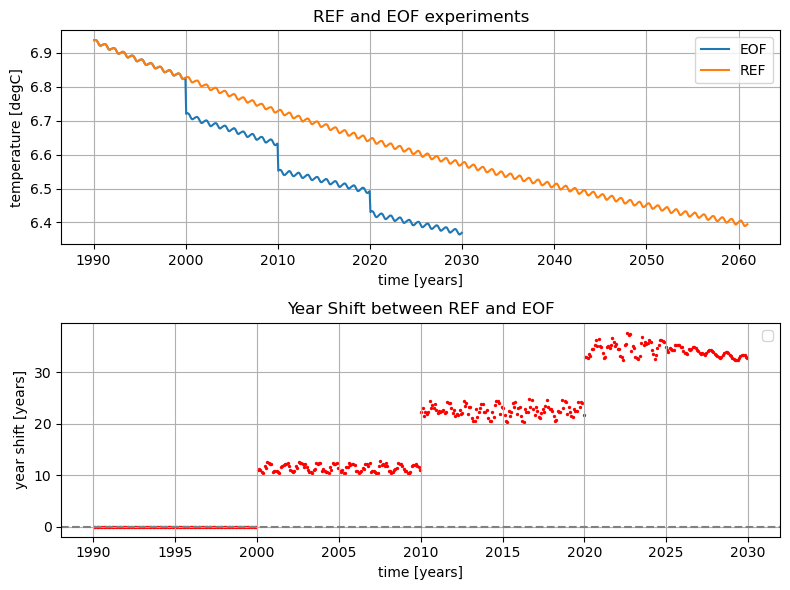

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from osprey.utils.time import get_decimal_year

# Function to calculate the horizontal shift between curve 1 and curve 2 relative to curve 1
def calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=20.0):
    # Interpolate curve 2 with respect to y-values to get x2 = f(y2)
    interp_curve2_inv = interp1d(y2, x2, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # List to store the horizontal shift for each point of curve 1
    shifts = []
    
    # Calculate the shift for each point in curve 1
    for i in range(len(x1)):
        y1_point = y1[i]  # y-value of curve 1
        x1_point = x1[i]  # x-value of curve 1

        # Find the corresponding x-value on curve 2 for the same y-value
        x2_point = interp_curve2_inv(y1_point)
        
        # Calculate the horizontal shift
        shift = x2_point - x1_point
        
        # Add a condition for the maximum acceptable shift threshold
        if abs(shift) > shift_threshold:
            shift = np.nan  # Ignore shifts that are too large (set to NaN)
        
        shifts.append(shift)
    
    return np.array(shifts)

# load data
df = elements('ORCA2')

data1 = reader_nemo(expname='FE01', startyear=1990, endyear=2029)
ave1 = data1['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y1 = ave1.compute()
x1 = get_decimal_year(data1['time'].values)

data2 = reader_nemo(expname='lfr0', startyear=1990, endyear=2060)
ave2 = data2['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y2 = ave2.compute()
x2 = get_decimal_year(data2['time'].values)

# Calculate the shift relative to curve 1 with a maximum shift threshold
shift = calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=50.)

# Create subplots: one for the curves and one for the horizontal shift
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the curves in the first subplot
ax1.plot(x1, y1, label='EOF')
ax1.plot(x2, y2, label='REF')
ax1.set_xlabel('time [years]')
ax1.set_ylabel('temperature [degC]')
ax1.set_title('REF and EOF experiments')
ax1.legend()
ax1.grid()

# Plot the horizontal shift in the second subplot
ax2.scatter(x1, shift, color='red', s=2)
ax2.axhline(0, color='gray', linestyle='--')  # Zero reference line
ax2.set_xlabel('time [years]')
ax2.set_ylabel('year shift [years]')
ax2.set_title('Year Shift between REF and EOF')
ax2.legend()
ax2.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

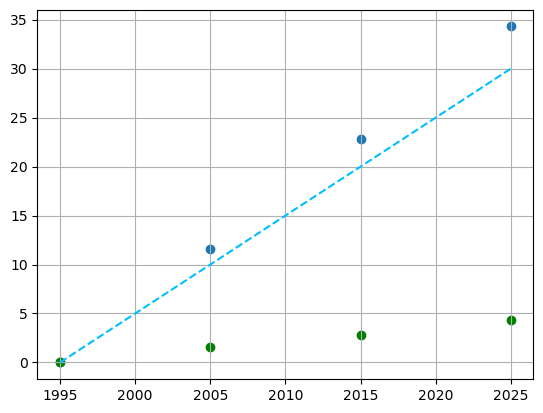

In [49]:
# Definire la dimensione di un gradino (10 anni = 120 mesi)
step_size = 121
# Suddividere l'array in intervalli di 120 mesi e calcolare la media per ciascun gradino
mean_values = [np.mean(shift[i:i + step_size]) for i in range(0, len(shift), step_size)]
mean_time = [int(np.mean(x1[i:i + step_size])) for i in range(0, len(x1), step_size)]
linear_curve = [mean_time[i]-1995 for i in range(0, len(mean_time))]
delta = [mean_values[i]-linear_curve[i] for i in range(0, len(mean_values))]
plt.scatter(mean_time, mean_values)
plt.plot(mean_time, linear_curve, color='deepskyblue', linestyle='--')
plt.scatter(mean_time, delta, color='green')
plt.grid()

2024-10-03 09:48:42,795 - INFO - Data available in the range 1990-2029.


2024-10-03 09:48:46,023 - INFO - Data available in the range 1990-2060.
/ec/res4/scratch/itas/tmp/ipykernel_3955647/3077123470.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


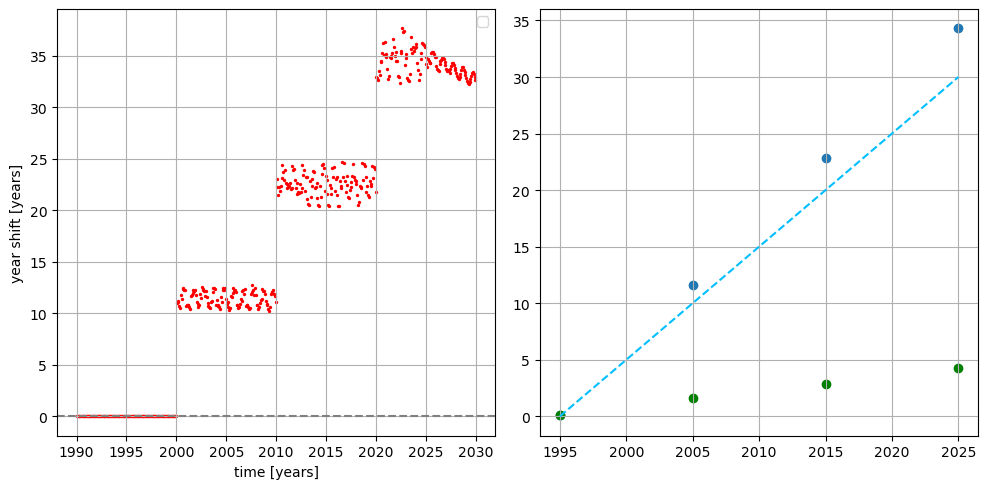

In [54]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from osprey.utils.time import get_decimal_year

# Function to calculate the horizontal shift between curve 1 and curve 2 relative to curve 1
def calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=20.0):
    # Interpolate curve 2 with respect to y-values to get x2 = f(y2)
    interp_curve2_inv = interp1d(y2, x2, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # List to store the horizontal shift for each point of curve 1
    shifts = []
    
    # Calculate the shift for each point in curve 1
    for i in range(len(x1)):
        y1_point = y1[i]  # y-value of curve 1
        x1_point = x1[i]  # x-value of curve 1

        # Find the corresponding x-value on curve 2 for the same y-value
        x2_point = interp_curve2_inv(y1_point)
        
        # Calculate the horizontal shift
        shift = x2_point - x1_point
        
        # Add a condition for the maximum acceptable shift threshold
        if abs(shift) > shift_threshold:
            shift = np.nan  # Ignore shifts that are too large (set to NaN)
        
        shifts.append(shift)
    
    return np.array(shifts)

# load data
df = elements('ORCA2')

data1 = reader_nemo(expname='FE01', startyear=1990, endyear=2029)
ave1 = data1['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y1 = ave1.compute()
x1 = get_decimal_year(data1['time'].values)

data2 = reader_nemo(expname='lfr0', startyear=1990, endyear=2060)
ave2 = data2['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y2 = ave2.compute()
x2 = get_decimal_year(data2['time'].values)

# Calculate the shift relative to curve 1 with a maximum shift threshold
shift = calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=50.)

# Create subplots: one for the curves and one for the horizontal shift
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the horizontal shift in the second subplot
ax1.scatter(x1, shift, color='red', s=2)
ax1.axhline(0, color='gray', linestyle='--')  # Zero reference line
ax1.set_xlabel('time [years]')
ax1.set_ylabel('year shift [years]')
ax1.legend()
ax1.grid()

# Definire la dimensione di un gradino (10 anni = 120 mesi)
step_size = 121
# Suddividere l'array in intervalli di 120 mesi e calcolare la media per ciascun gradino
mean_values = [np.mean(shift[i:i + step_size]) for i in range(0, len(shift), step_size)]
mean_time = [int(np.mean(x1[i:i + step_size])) for i in range(0, len(x1), step_size)]
linear_curve = [mean_time[i]-1995 for i in range(0, len(mean_time))]
delta = [mean_values[i]-linear_curve[i] for i in range(0, len(mean_values))]
ax2.scatter(mean_time, mean_values)
ax2.plot(mean_time, linear_curve, color='deepskyblue', linestyle='--')
ax2.scatter(mean_time, delta, color='green')
ax2.set_xlabel('time [years]')
ax2.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


2024-09-30 12:02:22,816 - INFO - Data available in the range 1990-2029.


2024-09-30 12:02:27,715 - INFO - Data available in the range 1990-2060.
/ec/res4/scratch/itas/tmp/ipykernel_2378677/1989777862.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


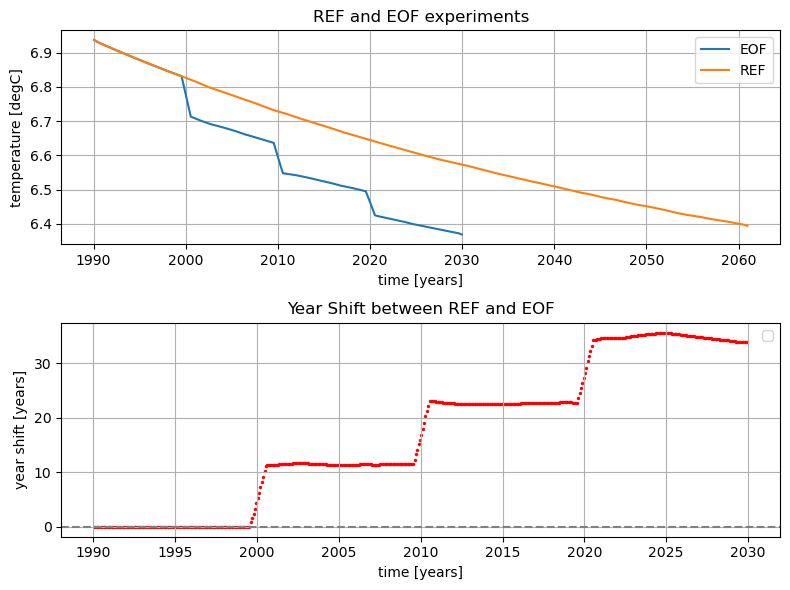

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from osprey.utils.time import get_decimal_year
from osprey.means.means import movave

# Function to calculate the horizontal shift between curve 1 and curve 2 relative to curve 1
def calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=20.0):
    # Interpolate curve 2 with respect to y-values to get x2 = f(y2)
    interp_curve2_inv = interp1d(y2, x2, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # List to store the horizontal shift for each point of curve 1
    shifts = []
    
    # Calculate the shift for each point in curve 1
    for i in range(len(x1)):
        y1_point = y1[i]  # y-value of curve 1
        x1_point = x1[i]  # x-value of curve 1

        # Find the corresponding x-value on curve 2 for the same y-value
        x2_point = interp_curve2_inv(y1_point)
        
        # Calculate the horizontal shift
        shift = x2_point - x1_point
        
        # Add a condition for the maximum acceptable shift threshold
        if abs(shift) > shift_threshold:
            shift = np.nan  # Ignore shifts that are too large (set to NaN)
        
        shifts.append(shift)
    
    return np.array(shifts)

# load data
df = elements('ORCA2')

data1 = reader_nemo(expname='FE01', startyear=1990, endyear=2029)
ave1 = data1['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y1 = movave(ave1,12)
#y1 = mave1.compute()
x1 = get_decimal_year(data1['time'].values)

data2 = reader_nemo(expname='lfr0', startyear=1990, endyear=2060)
ave2 = data2['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y2 = movave(ave2,12)
#y2 = mave2.compute()
x2 = get_decimal_year(data2['time'].values)

# Calculate the shift relative to curve 1 with a maximum shift threshold
shift = calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=50.)

# Create subplots: one for the curves and one for the horizontal shift
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the curves in the first subplot
ax1.plot(x1, y1, label='EOF')
ax1.plot(x2, y2, label='REF')
ax1.set_xlabel('time [years]')
ax1.set_ylabel('temperature [degC]')
ax1.set_title('REF and EOF experiments')
ax1.legend()
ax1.grid()

# Plot the horizontal shift in the second subplot
ax2.scatter(x1, shift, color='red', s=2)
ax2.axhline(0, color='gray', linestyle='--')  # Zero reference line
ax2.set_xlabel('time [years]')
ax2.set_ylabel('year shift [years]')
ax2.set_title('Year Shift between REF and EOF')
ax2.legend()
ax2.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import xarray as xr
from osprey.actions.reader import reader_nemo
from osprey.means.means import elements

df = elements('ORCA2')

data1 = reader_nemo(expname='lfr0', startyear=1990, endyear=2100, grid='U')
ave1 = data1['uo'].weighted(df['V']).mean(dim=['z', 'y', 'x'])

data2 = reader_nemo(expname='FE01', startyear=1990, endyear=2100, grid='U')
ave2 = data2['uo'].weighted(df['V']).mean(dim=['z', 'y', 'x'])

2024-10-04 09:26:01,285 - INFO - Data available in the range 1990-2100.
2024-10-04 09:26:11,724 - INFO - Data available in the range 1990-2100.


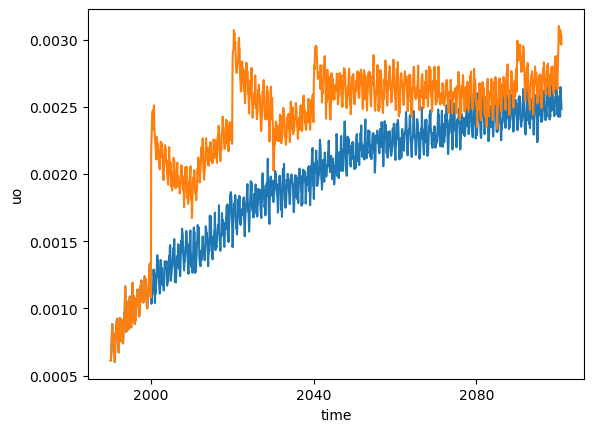

In [9]:
ave1.plot()
ave2.plot()